# Week 5: Monet Painting GAN - Kaggle Mini-Project
## Introduction
The goal of this week's mini-project is to compete in the Kaggle competition [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview) by using Generative Adversarial Networks (GANs) to generate art in the style of the painter [Claude Monet](https://en.wikipedia.org/wiki/Claude_Monet).

GANs are composed of at least a generator model and a disciminator model, where the generator tries to "trick" the discriminator by producing images that essentially impersonate the training data (*i.e.* confusing its ability to classify real vs generated images).

The quality of our generated images are evaluated according to Memorization-informed Fréchet Inception Distance (MiFID). **Our goal is to achieve the smallest MiFID with the images our GAN produces.**

The code for this project can be found at: https://github.com/buffs28349/MonetPaintingGAN

First, let's begin by importing the necessary libaries:

In [1]:
!pip install tensorflow_addons
!pip install pillow

In [1]:
# General (EDA, Plotting, etc)
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import PIL
import shutil

# Tensorflow/Keras for GAN work
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Define some useful constants
RAND_SEED = 123
DATA_PATH = "/kaggle/input/gan-getting-started"
EPOCHS = 50 # Will take a while with a CPU, try using a GPU on Kaggle
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3

2022-09-28 03:08:38.272739: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Next, we will load our datasets:

In [4]:
MONET_FILES = glob.glob(f"{DATA_PATH}/monet_tfrec/*.tfrec")
PHOTO_FILES = glob.glob(f"{DATA_PATH}/photo_tfrec/*.tfrec")

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(record):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, tfrecord_format)
    image = decode_image(parsed_record['image'])
    return image

def load_data(files):
    d = tf.data.TFRecordDataset(files)
    d = d.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return d

monet_data = load_data(MONET_FILES).batch(1)
photo_data = load_data(PHOTO_FILES).batch(1)

## Exploratory Data Analysis (EDA)
We are developing a GAN to generate images from a training set (Monet's paintings). In the previous **Introduction** section we loaded our dataset into `monet_data` and `photo_data`. We can imagine what this data might be, but it is still important as part of exploratory data analysis to be certain and take a look. First, `monet_data`:

2022-09-28 03:09:05.679434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-28 03:09:05.684035: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


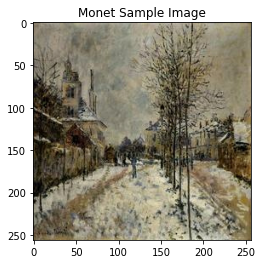

In [5]:
monet_sample_image = next(iter(monet_data))
plt.subplot(111)
plt.title('Monet Sample Image')
plt.imshow(monet_sample_image[0] * 0.5 + 0.5)

Beautiful! An example of what we expect: *a 256x256 pixel Monet painting.* Now a photo:

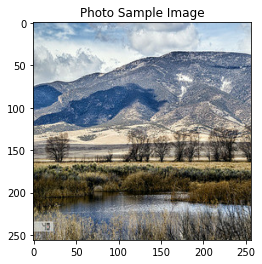

In [6]:
photo_sample_image = next(iter(photo_data))
plt.subplot(111)
plt.title('Photo Sample Image')
plt.imshow(photo_sample_image[0] * 0.5 + 0.5)

What a picturesque photo. If it isn't already obvious, we will be training on the images in `monet_data` and utilizing the GAN to generate Monet-style images from the source images in `photo_data`. The photos, too, are 256x256 pixels.

To get a feel for the amount of training data we have, and the number source images we must generate, let's take a look at the size of both `monet_data` and `photo_data`, each of which were loaded from the collections of [TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord) in the `data/monet_tfrec/` and `data/photo_tfrec` directories, respectively.

There are 300 Monet training images.
There are 7038 photo target images.


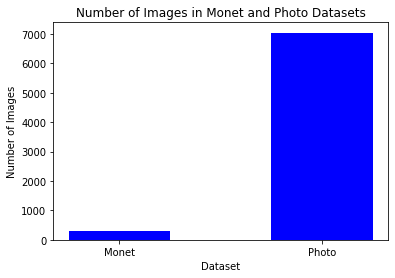

In [7]:
num_monet = len(list(monet_data))
num_photo = len(list(photo_data))

print(f"There are {num_monet} Monet training images.")
print(f"There are {num_photo} photo target images.")

plt.subplot(111)
plt.bar(["Monet", "Photo"], [num_monet, num_photo], color = 'blue', width = 0.5)
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.title("Number of Images in Monet and Photo Datasets")
plt.show()

We have only 300 Monet training images, but that is more than enough to create a strong model for this Kaggle competition. We will be producing 7038 Monet-style iamges from the photos in `photo_data`.

Now on to model building and training!

## Analysis (Model Building + Training)
We will be utilizing a [Deep Convolutionl Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) (DCGAN) for our model. We will be using this because Tensorflow has strong support for this type of GAN, and it was taught to us in this week's class lectures - making it a fitting choice for a real-world example!

I was inspired by the code [from here](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook). However, I improved on the process myself for a more performant and effective training procedure specific to the requirements for our mini-project this week. ***The work is entirely my own.***

### Generator
The first part of a GAN is of course the generator. We start by creating helper functions, `downsample` and `upsample` to be used when creating the generator.

Our generator consists of first downsampling our Monet painting images, before upscaling them back to the required resolution (256x256). This CNN (the "DC" in DCGAN) process allows us to more thoroughly iterate on the learning procedure, providing many benefits - most notably, a better loss value and therefore enhanced output quality.

In [9]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

After defining our `downsample` and `upsample` functions we can use them to assemble the layers of our generator:

In [11]:
def make_generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh')

    x = inputs

    # Perform downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Perform upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)
    
generator = make_generator()

Let's view the generator's summary to confirm it produced the layers that we expect:

In [12]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  524800      sequential_1[0][0]               
______________________________________________________________________________________________

### Discriminator
Next is the discriminator. It is similar to the generator but without upsampling. Essentially our layers will continuously refine its understanding of the image before being used to make a decision as to whether the image is a real Monet or a fake: binary classification.

In [13]:
def make_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

discriminator = make_discriminator()

And the discriminator's summary:

In [14]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_16 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_17 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_16 (I (None, 31, 31, 512)       1024

**Important Note:** Since we have not yet trained the generator, its output will be nothing of value to us. This is demonstrated below:

2022-09-28 03:10:08.354159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-09-28 03:10:14.284532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-28 03:10:15.281383: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


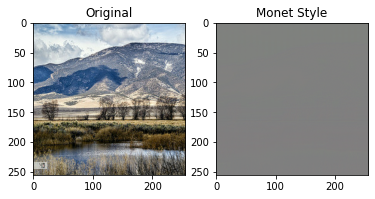

In [15]:
to_monet = generator(photo_sample_image)

plt.subplot(121)
plt.title("Original")
plt.imshow(photo_sample_image[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Monet Style")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Training
Now this is where the magic happens. We subclass `keras.Model` and create our own `MonetGAN` from it. Specifically, we will override the `train_step` to better track the quality of our data during fitting, as well as customize the generator/discriminator relationship of the GAN itself.

In [16]:
class MonetGAN(keras.Model):
    def __init__(self, generator, discriminator,):
        super(MonetGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, gen_loss_fn, disc_loss_fn):
        super(MonetGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake Monets from input photos
            fake_monet = self.generator(real_photo, training=True)
            
            # Discriminator
            disc_real_monet = self.discriminator(real_monet, training=True)
            disc_fake_monet = self.discriminator(fake_monet, training=True)

            # Generator loss
            gen_loss = self.gen_loss_fn(disc_fake_monet)
            
            # Discriminator loss
            disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)

        # Calculate gradients
        generator_gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        discriminator_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        # Apply gradients to optimizer
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
        
        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
        }

Lastly, we must define our loss functions. These compare the real images and fake images. A "perfect" discriminator will produce all correct, or true values (that is `1`s) and a poor generator all incorrect values (`0`s).

It has already been said, but is worth repeating: to incredible power of the GAN is combining these together so that the discriminator improves the generator by identifying real vs fakes, thus requiring the generator to improve itself to "trick" the discriminator.

In [17]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

Now we may perform the actual training:

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

monet_model = MonetGAN(generator, discriminator)

monet_model.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

monet_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs=EPOCHS)

Epoch 1/50
300/300 [==============================] - 25s 55ms/step - gen_loss: 0.7703 - disc_loss: 0.6407
Epoch 2/50
300/300 [==============================] - 16s 54ms/step - gen_loss: 0.7678 - disc_loss: 0.6552
Epoch 3/50
300/300 [==============================] - 16s 55ms/step - gen_loss: 0.8287 - disc_loss: 0.6296
Epoch 4/50
300/300 [==============================] - 16s 54ms/step - gen_loss: 0.8763 - disc_loss: 0.6153
Epoch 5/50
300/300 [==============================] - 16s 55ms/step - gen_loss: 0.8379 - disc_loss: 0.6412
Epoch 6/50
300/300 [==============================] - 16s 54ms/step - gen_loss: 0.7974 - disc_loss: 0.6602
Epoch 7/50
300/300 [==============================] - 16s 55ms/step - gen_loss: 0.7788 - disc_loss: 0.6668
Epoch 8/50
300/300 [==============================] - 16s 54ms/step - gen_loss: 0.7673 - disc_loss: 0.6670
Epoch 9/50
300/300 [==============================] - 16s 55ms/step - gen_loss: 0.7770 - disc_loss: 0.6616
Epoch 10/50
300/300 [================

## Results
We have trained our model! Let's see what it can do:

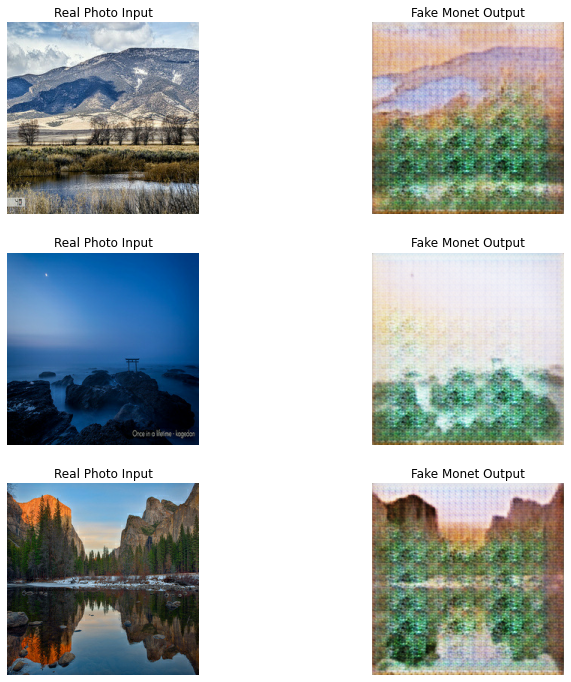

In [19]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(3)):
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Real Photo Input")
    ax[i, 1].set_title("Fake Monet Output")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Create File for Submission
The Kaggle competition expects an `image.zip` file containing our Monet-styled photos.

In [27]:
!mkdir -p /kaggle/tmp/output

In [28]:
i = 1
for img in photo_data:
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/tmp/output/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/tmp/output")

'/kaggle/working/images.zip'

## Discussion/Conclusion
Altogether, this was a successful project. Our model after 50 epochs managed to achieve a `0.7991` loss in our generator and a `0.6589` loss in our discriminator. Not the greatest quality, but a strong performance regardless. I may not be an artist, but our generated images are uncannily similar to Monet's style, too! This was a great project to learn about GANs and to apply a practical real-world problem to them.